Computing free energy differences with two Boltzmann generators
------
Here we construct two Boltzmann generators (x <--> z) and (y <-->z) that map two different parts of configuration space to the same latent space. We then sample from latent space and compute free energy differences between the two sets of configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
import pyemma
from pyemma.util.statistics import confidence_interval

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

/Users/noe/anaconda/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.3.
  .format(latest=latest, current=current), category=UserWarning)


In [5]:
from deep_boltzmann.models import MuellerPotential
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def getx(x):
    return x[:, 0]

Mueller potential
---

In [7]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

In [8]:
params = MuellerPotential.params_default.copy()
params['k'] = 0.1
params['dim'] = 2
mueller = MuellerPotential(params=params)

In [9]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4)):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$ / a.u.')
        plt.ylabel('$x_2$ / a.u.')
    else:
        plt.xticks([])
        plt.yticks([])
    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')

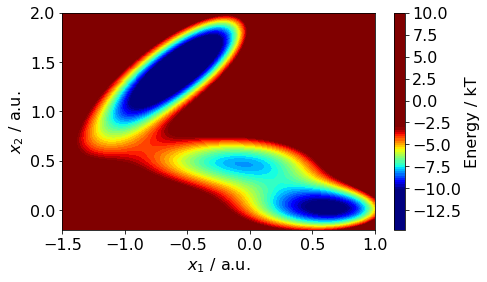

In [10]:
plot_potential(labels=True, cbar=True)

In [11]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [12]:
nsteps = 1000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.05, stride=1)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

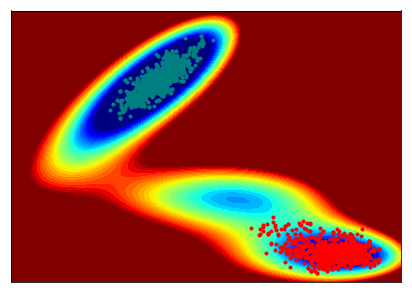

In [13]:
plot_potential(labels=False, cbar=False, figsize=(7, 5))
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/mueller/xdist_2BGs.pdf', bbox_inches='tight')

Train two BG's on separate trajectories
-------

In [37]:
batchsize_ML = 128
batchsize_KL = 1000
temperature = [0.25, 0.5, 1.0, 2.0, 3.0]
temperatures_analysis = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]

In [38]:
# REFERENCE
# Projection coordinate:
proj_dir = np.array([[0.7],[-0.7]])
# Reference calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_proj = xwild.dot(proj_dir)
dF_true = []
for T in temperatures_analysis:
    xwild_w = np.exp(-(xwild_ener-xwild_ener.min()) / T)
    hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
    bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])
    w_left = np.sum(hist_ref[bin_values_ref<-1])
    w_middle = np.sum(hist_ref[np.logical_and(bin_values_ref>-1, bin_values_ref<0)])
    w_right = np.sum(hist_ref[bin_values_ref>0])    
    dF_true.append(-np.log(w_right / w_left))

In [39]:
def train_and_sample_free_energy(trainer, model, xtrain, temperatures_analysis, 
                                 nsample=100, nepochs_per_iter=10, niter=100, train_batchsize=None):
    bg = trainer.bg
    # Train and sample for multiple temperatures
    F_by_temp = [[] for T in temperatures_analysis]
    Ex_by_temp = [[] for T in temperatures_analysis]
    Jzx_by_temp = [[] for T in temperatures_analysis]
    for i in range(niter):  # training iteration
        print(i, '/', niter)
        if train_batchsize is None:
            trainer.train(xtrain, epochs=nepochs_per_iter)
        else:
            trainer.train(xtrain, epochs=nepochs_per_iter, batch_size=train_batchsize)
        for t, T in enumerate(temperatures_analysis):  # temperature iteration
            samples_z = np.sqrt(T) * np.random.randn(nsample, model.dim)
            samples_x, samples_Jzx = bg.transform_zxJ(samples_z)
            samples_enerx = model.energy(samples_x)
            Ex_by_temp[t].append(samples_enerx)
            Jzx_by_temp[t].append(samples_Jzx)     
    for t, T in enumerate(temperatures_analysis):  # temperature iteration
        F_by_temp[t] = np.concatenate(Ex_by_temp[t]) / T - np.concatenate(Jzx_by_temp[t])
        #Ex_by_temp[t] = np.concatenate(Ex_by_temp[t])
        #Jzx_by_temp[t] = np.concatenate(Jzx_by_temp[t])
    return F_by_temp

In [78]:
def dF_running_mean(dFs, window=100, step=1, dF_cut=50):
    dF_runningmean = []
    for i in range(0, dFs.size-window, step):
        chunk = dFs[i:i+window]
        chunk_reg = chunk[np.logical_and(chunk > -dF_cut, chunk < dF_cut)]
        dF_runningmean.append(mean_finite(chunk_reg))
    return dF_runningmean

In [41]:
bg1 = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
             nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [42]:
bg2 = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
             nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [43]:
mltrainer1 = MLTrainer(bg1, lr=0.001)
mltrainer2 = MLTrainer(bg2, lr=0.001)

Compiling the graph
Compiling the graph


In [44]:
F1_ML_by_temp = train_and_sample_free_energy(mltrainer1, mueller, traj_left, temperatures_analysis, 
                                             train_batchsize=128, nsample=1000, nepochs_per_iter=10, niter=20)
F2_ML_by_temp = train_and_sample_free_energy(mltrainer2, mueller, traj_right, temperatures_analysis, 
                                             train_batchsize=128, nsample=1000, nepochs_per_iter=10, niter=20)

0 / 20
Epoch 0/10 loss 1.1226 
Epoch 1/10 loss 0.8119 
Epoch 2/10 loss 0.5636 
Epoch 3/10 loss 0.3473 
Epoch 4/10 loss 0.1867 
Epoch 5/10 loss 0.0598 
Epoch 6/10 loss -0.0692 
Epoch 7/10 loss -0.2134 
Epoch 8/10 loss -0.3959 
Epoch 9/10 loss -0.5230 


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


1 / 20
Epoch 0/10 loss -0.6429 
Epoch 1/10 loss -0.8766 
Epoch 2/10 loss -0.9637 
Epoch 3/10 loss -1.1845 
Epoch 4/10 loss -1.3927 
Epoch 5/10 loss -1.4241 
Epoch 6/10 loss -1.6460 
Epoch 7/10 loss -1.8995 
Epoch 8/10 loss -1.7477 
Epoch 9/10 loss -1.7256 


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in multiply
  self.cc[j] * (x2 - self.YY[j])**2)


2 / 20
Epoch 0/10 loss -2.0562 
Epoch 1/10 loss -2.1160 
Epoch 2/10 loss -2.1288 
Epoch 3/10 loss -2.2889 
Epoch 4/10 loss -2.3833 
Epoch 5/10 loss -2.4836 
Epoch 6/10 loss -2.4636 
Epoch 7/10 loss -2.5715 
Epoch 8/10 loss -2.5398 
Epoch 9/10 loss -2.6678 
3 / 20
Epoch 0/10 loss -2.6762 
Epoch 1/10 loss -2.7976 
Epoch 2/10 loss -2.3855 
Epoch 3/10 loss -2.7177 
Epoch 4/10 loss -2.3109 
Epoch 5/10 loss -2.6039 
Epoch 6/10 loss -2.6206 
Epoch 7/10 loss -2.7944 
Epoch 8/10 loss -2.8818 
Epoch 9/10 loss -2.9300 
4 / 20
Epoch 0/10 loss -3.0466 
Epoch 1/10 loss -2.9397 
Epoch 2/10 loss -3.0432 
Epoch 3/10 loss -3.0710 
Epoch 4/10 loss -3.0333 
Epoch 5/10 loss -3.2985 
Epoch 6/10 loss -2.8685 
Epoch 7/10 loss -2.9089 
Epoch 8/10 loss -2.8460 
Epoch 9/10 loss -2.6776 
5 / 20
Epoch 0/10 loss -3.0494 
Epoch 1/10 loss -3.3601 
Epoch 2/10 loss -3.3793 
Epoch 3/10 loss -3.4025 
Epoch 4/10 loss -3.5204 
Epoch 5/10 loss -3.2443 
Epoch 6/10 loss -3.2741 
Epoch 7/10 loss -3.3189 
Epoch 8/10 loss -3.219

Epoch 9/10 loss -3.6942 
14 / 20
Epoch 0/10 loss -3.6571 
Epoch 1/10 loss -3.4280 
Epoch 2/10 loss -3.7414 
Epoch 3/10 loss -3.7036 
Epoch 4/10 loss -3.4889 
Epoch 5/10 loss -3.6339 
Epoch 6/10 loss -3.6229 
Epoch 7/10 loss -3.5772 
Epoch 8/10 loss -3.6568 
Epoch 9/10 loss -3.5874 
15 / 20
Epoch 0/10 loss -3.8605 
Epoch 1/10 loss -3.8354 
Epoch 2/10 loss -3.7331 
Epoch 3/10 loss -3.6113 
Epoch 4/10 loss -3.6297 
Epoch 5/10 loss -3.7353 
Epoch 6/10 loss -3.6315 
Epoch 7/10 loss -3.5547 
Epoch 8/10 loss -3.7599 
Epoch 9/10 loss -3.5228 
16 / 20
Epoch 0/10 loss -3.7017 
Epoch 1/10 loss -3.6686 
Epoch 2/10 loss -3.7130 
Epoch 3/10 loss -3.7323 
Epoch 4/10 loss -3.6235 
Epoch 5/10 loss -3.5872 
Epoch 6/10 loss -3.7307 
Epoch 7/10 loss -3.8239 
Epoch 8/10 loss -3.6655 
Epoch 9/10 loss -3.6798 
17 / 20
Epoch 0/10 loss -3.7371 
Epoch 1/10 loss -3.6372 
Epoch 2/10 loss -3.8095 
Epoch 3/10 loss -3.5451 
Epoch 4/10 loss -3.8376 
Epoch 5/10 loss -3.6479 
Epoch 6/10 loss -3.5946 
Epoch 7/10 loss -3

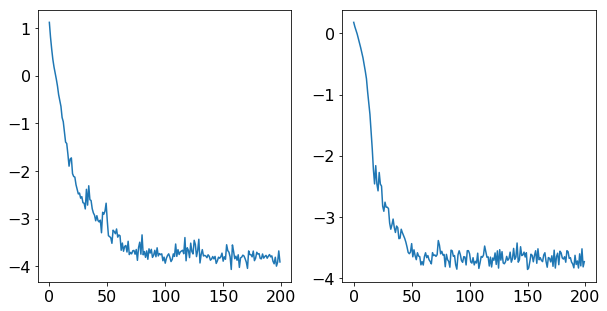

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(mltrainer1.loss_train)
axes[1].plot(mltrainer2.loss_train)

In [46]:
flextrainer1 = FlexibleTrainer(bg1, lr=0.0001, batch_size=batchsize_KL, high_energy=10000, w_ML=1.0, w_KL=1.0, 
                               temperature=temperature, weigh_ML=False)
flextrainer2 = FlexibleTrainer(bg2, lr=0.0001, batch_size=batchsize_KL, high_energy=10000, w_ML=1.0, w_KL=1.0, 
                               temperature=temperature, weigh_ML=False)

In [47]:
F1_KL_by_temp = train_and_sample_free_energy(flextrainer1, mueller, traj_left, temperatures_analysis, 
                                             nsample=1000, nepochs_per_iter=10, niter=50)
F2_KL_by_temp = train_and_sample_free_energy(flextrainer2, mueller, traj_right, temperatures_analysis, 
                                             nsample=1000, nepochs_per_iter=10, niter=50)

0 / 50
Epoch 0/10 loss -20.7245 index_layer_15_loss -3.7721 index_layer_18_loss -16.9524 
Epoch 1/10 loss -20.5334 index_layer_15_loss -3.8686 index_layer_18_loss -16.6648 
Epoch 2/10 loss -20.6114 index_layer_15_loss -3.8691 index_layer_18_loss -16.7423 
Epoch 3/10 loss -20.6420 index_layer_15_loss -3.8918 index_layer_18_loss -16.7502 
Epoch 4/10 loss -20.8735 index_layer_15_loss -3.8542 index_layer_18_loss -17.0193 
Epoch 5/10 loss -20.3212 index_layer_15_loss -3.7850 index_layer_18_loss -16.5363 
Epoch 6/10 loss -20.6053 index_layer_15_loss -3.8294 index_layer_18_loss -16.7759 
Epoch 7/10 loss -18.7207 index_layer_15_loss -3.8580 index_layer_18_loss -14.8627 
Epoch 8/10 loss -20.5332 index_layer_15_loss -3.8567 index_layer_18_loss -16.6765 
Epoch 9/10 loss -20.5647 index_layer_15_loss -3.8446 index_layer_18_loss -16.7201 
1 / 50
Epoch 0/10 loss -20.4970 index_layer_15_loss -3.9039 index_layer_18_loss -16.5931 
Epoch 1/10 loss -20.7857 index_layer_15_loss -3.8895 index_layer_18_loss 

Epoch 8/10 loss -20.8074 index_layer_15_loss -3.8355 index_layer_18_loss -16.9718 
Epoch 9/10 loss -20.9079 index_layer_15_loss -3.9238 index_layer_18_loss -16.9841 
10 / 50
Epoch 0/10 loss -20.9096 index_layer_15_loss -3.8540 index_layer_18_loss -17.0556 
Epoch 1/10 loss -20.9195 index_layer_15_loss -3.8812 index_layer_18_loss -17.0383 
Epoch 2/10 loss -20.8560 index_layer_15_loss -3.8473 index_layer_18_loss -17.0087 
Epoch 3/10 loss -20.8919 index_layer_15_loss -3.8834 index_layer_18_loss -17.0085 
Epoch 4/10 loss -20.8532 index_layer_15_loss -3.8872 index_layer_18_loss -16.9660 
Epoch 5/10 loss -20.9367 index_layer_15_loss -3.9084 index_layer_18_loss -17.0283 
Epoch 6/10 loss -20.8446 index_layer_15_loss -3.8799 index_layer_18_loss -16.9647 
Epoch 7/10 loss -20.7788 index_layer_15_loss -3.8846 index_layer_18_loss -16.8943 
Epoch 8/10 loss -20.8696 index_layer_15_loss -3.8993 index_layer_18_loss -16.9702 
Epoch 9/10 loss -20.8644 index_layer_15_loss -3.8157 index_layer_18_loss -17.04

Epoch 6/10 loss -20.8465 index_layer_15_loss -3.8328 index_layer_18_loss -17.0137 
Epoch 7/10 loss -20.8506 index_layer_15_loss -3.8114 index_layer_18_loss -17.0392 
Epoch 8/10 loss -20.8802 index_layer_15_loss -3.8831 index_layer_18_loss -16.9971 
Epoch 9/10 loss -21.0091 index_layer_15_loss -3.8946 index_layer_18_loss -17.1145 
20 / 50
Epoch 0/10 loss -20.9145 index_layer_15_loss -3.9082 index_layer_18_loss -17.0063 
Epoch 1/10 loss -20.8397 index_layer_15_loss -3.8754 index_layer_18_loss -16.9644 
Epoch 2/10 loss -20.8742 index_layer_15_loss -3.8567 index_layer_18_loss -17.0175 
Epoch 3/10 loss -20.8275 index_layer_15_loss -3.8341 index_layer_18_loss -16.9935 
Epoch 4/10 loss -20.8986 index_layer_15_loss -3.8433 index_layer_18_loss -17.0552 
Epoch 5/10 loss -20.9123 index_layer_15_loss -3.8518 index_layer_18_loss -17.0604 
Epoch 6/10 loss -20.9628 index_layer_15_loss -3.8544 index_layer_18_loss -17.1084 
Epoch 7/10 loss -20.8872 index_layer_15_loss -3.8440 index_layer_18_loss -17.04

Epoch 4/10 loss -20.9117 index_layer_15_loss -3.8694 index_layer_18_loss -17.0423 
Epoch 5/10 loss -20.9426 index_layer_15_loss -3.8961 index_layer_18_loss -17.0465 
Epoch 6/10 loss -20.9208 index_layer_15_loss -3.8721 index_layer_18_loss -17.0487 
Epoch 7/10 loss -20.9209 index_layer_15_loss -3.8324 index_layer_18_loss -17.0885 
Epoch 8/10 loss -20.9307 index_layer_15_loss -3.9038 index_layer_18_loss -17.0269 
Epoch 9/10 loss -20.8794 index_layer_15_loss -3.8626 index_layer_18_loss -17.0168 
30 / 50
Epoch 0/10 loss -20.9251 index_layer_15_loss -3.8769 index_layer_18_loss -17.0482 
Epoch 1/10 loss -21.0020 index_layer_15_loss -3.9160 index_layer_18_loss -17.0860 
Epoch 2/10 loss -20.8066 index_layer_15_loss -3.8472 index_layer_18_loss -16.9594 
Epoch 3/10 loss -20.8405 index_layer_15_loss -3.8113 index_layer_18_loss -17.0292 
Epoch 4/10 loss -20.8840 index_layer_15_loss -3.8399 index_layer_18_loss -17.0441 
Epoch 5/10 loss -20.9362 index_layer_15_loss -3.8500 index_layer_18_loss -17.08

Epoch 2/10 loss -20.8889 index_layer_15_loss -3.8552 index_layer_18_loss -17.0337 
Epoch 3/10 loss -20.8886 index_layer_15_loss -3.8029 index_layer_18_loss -17.0856 
Epoch 4/10 loss -20.9483 index_layer_15_loss -3.8642 index_layer_18_loss -17.0841 
Epoch 5/10 loss -20.9378 index_layer_15_loss -3.8668 index_layer_18_loss -17.0709 
Epoch 6/10 loss -20.8999 index_layer_15_loss -3.8853 index_layer_18_loss -17.0146 
Epoch 7/10 loss -20.9014 index_layer_15_loss -3.8430 index_layer_18_loss -17.0583 
Epoch 8/10 loss -20.9719 index_layer_15_loss -3.8539 index_layer_18_loss -17.1180 
Epoch 9/10 loss -20.9050 index_layer_15_loss -3.7963 index_layer_18_loss -17.1087 
40 / 50
Epoch 0/10 loss -20.8729 index_layer_15_loss -3.8267 index_layer_18_loss -17.0462 
Epoch 1/10 loss -20.9208 index_layer_15_loss -3.8700 index_layer_18_loss -17.0508 
Epoch 2/10 loss -21.0327 index_layer_15_loss -3.9069 index_layer_18_loss -17.1258 
Epoch 3/10 loss -20.9260 index_layer_15_loss -3.8633 index_layer_18_loss -17.06

49 / 50
Epoch 0/10 loss -20.9839 index_layer_15_loss -3.8800 index_layer_18_loss -17.1039 
Epoch 1/10 loss -20.9127 index_layer_15_loss -3.9024 index_layer_18_loss -17.0103 
Epoch 2/10 loss -20.9347 index_layer_15_loss -3.8614 index_layer_18_loss -17.0733 
Epoch 3/10 loss -20.8734 index_layer_15_loss -3.7954 index_layer_18_loss -17.0780 
Epoch 4/10 loss -20.8650 index_layer_15_loss -3.8232 index_layer_18_loss -17.0418 
Epoch 5/10 loss -20.8505 index_layer_15_loss -3.7904 index_layer_18_loss -17.0600 
Epoch 6/10 loss -20.9631 index_layer_15_loss -3.8946 index_layer_18_loss -17.0685 
Epoch 7/10 loss -21.0134 index_layer_15_loss -3.8804 index_layer_18_loss -17.1330 
Epoch 8/10 loss -20.9326 index_layer_15_loss -3.8586 index_layer_18_loss -17.0740 
Epoch 9/10 loss -20.8816 index_layer_15_loss -3.7865 index_layer_18_loss -17.0951 
0 / 50
Epoch 0/10 loss -14.5243 index_layer_21_loss -3.7018 index_layer_24_loss -10.8224 
Epoch 1/10 loss -12.1602 index_layer_21_loss -3.7307 index_layer_24_loss

Epoch 8/10 loss -14.6771 index_layer_21_loss -3.6601 index_layer_24_loss -11.0170 
Epoch 9/10 loss -14.7850 index_layer_21_loss -3.6834 index_layer_24_loss -11.1016 
9 / 50
Epoch 0/10 loss -14.7258 index_layer_21_loss -3.6833 index_layer_24_loss -11.0425 
Epoch 1/10 loss -14.7961 index_layer_21_loss -3.7266 index_layer_24_loss -11.0695 
Epoch 2/10 loss -14.6583 index_layer_21_loss -3.6847 index_layer_24_loss -10.9736 
Epoch 3/10 loss -14.7535 index_layer_21_loss -3.7428 index_layer_24_loss -11.0107 
Epoch 4/10 loss -14.7343 index_layer_21_loss -3.6972 index_layer_24_loss -11.0371 
Epoch 5/10 loss -14.8021 index_layer_21_loss -3.7276 index_layer_24_loss -11.0746 
Epoch 6/10 loss -14.7087 index_layer_21_loss -3.7024 index_layer_24_loss -11.0064 
Epoch 7/10 loss -14.7068 index_layer_21_loss -3.6267 index_layer_24_loss -11.0802 
Epoch 8/10 loss -14.8222 index_layer_21_loss -3.7066 index_layer_24_loss -11.1156 
Epoch 9/10 loss -14.7351 index_layer_21_loss -3.6734 index_layer_24_loss -11.061

Epoch 6/10 loss -14.6494 index_layer_21_loss -3.6564 index_layer_24_loss -10.9930 
Epoch 7/10 loss -14.7356 index_layer_21_loss -3.6834 index_layer_24_loss -11.0522 
Epoch 8/10 loss -14.7876 index_layer_21_loss -3.6641 index_layer_24_loss -11.1234 
Epoch 9/10 loss -14.6511 index_layer_21_loss -3.5994 index_layer_24_loss -11.0517 
19 / 50
Epoch 0/10 loss -14.7909 index_layer_21_loss -3.6589 index_layer_24_loss -11.1320 
Epoch 1/10 loss -14.7280 index_layer_21_loss -3.6813 index_layer_24_loss -11.0467 
Epoch 2/10 loss -14.7679 index_layer_21_loss -3.6961 index_layer_24_loss -11.0717 
Epoch 3/10 loss -14.7208 index_layer_21_loss -3.6475 index_layer_24_loss -11.0733 
Epoch 4/10 loss -14.8124 index_layer_21_loss -3.7471 index_layer_24_loss -11.0653 
Epoch 5/10 loss -14.7082 index_layer_21_loss -3.6752 index_layer_24_loss -11.0330 
Epoch 6/10 loss -14.8471 index_layer_21_loss -3.6711 index_layer_24_loss -11.1760 
Epoch 7/10 loss -14.6883 index_layer_21_loss -3.6525 index_layer_24_loss -11.03

Epoch 4/10 loss -14.7068 index_layer_21_loss -3.6267 index_layer_24_loss -11.0800 
Epoch 5/10 loss -14.7524 index_layer_21_loss -3.6296 index_layer_24_loss -11.1228 
Epoch 6/10 loss -14.7722 index_layer_21_loss -3.6504 index_layer_24_loss -11.1218 
Epoch 7/10 loss -14.7874 index_layer_21_loss -3.6519 index_layer_24_loss -11.1355 
Epoch 8/10 loss -14.8192 index_layer_21_loss -3.7049 index_layer_24_loss -11.1143 
Epoch 9/10 loss -14.7223 index_layer_21_loss -3.6494 index_layer_24_loss -11.0729 
29 / 50
Epoch 0/10 loss -14.8010 index_layer_21_loss -3.6740 index_layer_24_loss -11.1270 
Epoch 1/10 loss -14.7889 index_layer_21_loss -3.7028 index_layer_24_loss -11.0861 
Epoch 2/10 loss -14.7528 index_layer_21_loss -3.6519 index_layer_24_loss -11.1009 
Epoch 3/10 loss -14.7589 index_layer_21_loss -3.7328 index_layer_24_loss -11.0261 
Epoch 4/10 loss -14.8176 index_layer_21_loss -3.6637 index_layer_24_loss -11.1539 
Epoch 5/10 loss -14.8562 index_layer_21_loss -3.7085 index_layer_24_loss -11.14

Epoch 2/10 loss -14.8076 index_layer_21_loss -3.7268 index_layer_24_loss -11.0807 
Epoch 3/10 loss -14.7919 index_layer_21_loss -3.6919 index_layer_24_loss -11.1000 
Epoch 4/10 loss -14.8277 index_layer_21_loss -3.6908 index_layer_24_loss -11.1369 
Epoch 5/10 loss -14.8428 index_layer_21_loss -3.6813 index_layer_24_loss -11.1615 
Epoch 6/10 loss -14.7443 index_layer_21_loss -3.7108 index_layer_24_loss -11.0335 
Epoch 7/10 loss -14.8132 index_layer_21_loss -3.7269 index_layer_24_loss -11.0862 
Epoch 8/10 loss -14.8216 index_layer_21_loss -3.6646 index_layer_24_loss -11.1570 
Epoch 9/10 loss -14.7318 index_layer_21_loss -3.6650 index_layer_24_loss -11.0668 
39 / 50
Epoch 0/10 loss -14.7370 index_layer_21_loss -3.6438 index_layer_24_loss -11.0932 
Epoch 1/10 loss -14.8091 index_layer_21_loss -3.7113 index_layer_24_loss -11.0978 
Epoch 2/10 loss -14.8055 index_layer_21_loss -3.6478 index_layer_24_loss -11.1577 
Epoch 3/10 loss -14.7936 index_layer_21_loss -3.6423 index_layer_24_loss -11.15

48 / 50
Epoch 0/10 loss -14.7738 index_layer_21_loss -3.6686 index_layer_24_loss -11.1052 
Epoch 1/10 loss -14.9131 index_layer_21_loss -3.7433 index_layer_24_loss -11.1698 
Epoch 2/10 loss -13.4472 index_layer_21_loss -3.6835 index_layer_24_loss -9.7637 


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


Epoch 3/10 loss -14.8134 index_layer_21_loss -3.7026 index_layer_24_loss -11.1108 
Epoch 4/10 loss -14.7760 index_layer_21_loss -3.6657 index_layer_24_loss -11.1103 
Epoch 5/10 loss -14.7449 index_layer_21_loss -3.6256 index_layer_24_loss -11.1193 
Epoch 6/10 loss -14.8741 index_layer_21_loss -3.7428 index_layer_24_loss -11.1313 
Epoch 7/10 loss -14.7458 index_layer_21_loss -3.6328 index_layer_24_loss -11.1130 
Epoch 8/10 loss -14.8918 index_layer_21_loss -3.7663 index_layer_24_loss -11.1255 
Epoch 9/10 loss -14.7880 index_layer_21_loss -3.6499 index_layer_24_loss -11.1381 
49 / 50
Epoch 0/10 loss -14.8516 index_layer_21_loss -3.7132 index_layer_24_loss -11.1384 
Epoch 1/10 loss -14.7443 index_layer_21_loss -3.6226 index_layer_24_loss -11.1217 
Epoch 2/10 loss -14.8456 index_layer_21_loss -3.6867 index_layer_24_loss -11.1589 
Epoch 3/10 loss -14.7148 index_layer_21_loss -3.6484 index_layer_24_loss -11.0664 
Epoch 4/10 loss -14.8405 index_layer_21_loss -3.6800 index_layer_24_loss -11.16

In [48]:
F1_by_temp = np.hstack([F1_ML_by_temp, F1_KL_by_temp])
F2_by_temp = np.hstack([F2_ML_by_temp, F2_KL_by_temp])
dF_temp05 = (F2_by_temp-F1_by_temp)[7]
dF_temp10 = (F2_by_temp-F1_by_temp)[10]
dF_temp20 = (F2_by_temp-F1_by_temp)[14]

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract


(0, 12)

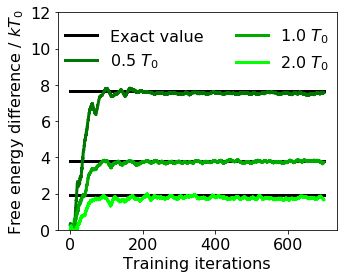

In [49]:
plt.figure(figsize=(5, 4))
dF_temp05_runningmean = dF_running_mean(dF_temp05, window=1000, step=10, dF_cut=10)
dF_temp10_runningmean = dF_running_mean(dF_temp10, window=1000, step=10, dF_cut=10)
dF_temp20_runningmean = dF_running_mean(dF_temp20, window=1000, step=10, dF_cut=10)
xrange = np.linspace(0, 700, len(dF_temp10_runningmean))
plt.plot([xrange[0], xrange[-1]], [dF_true[7], dF_true[7]], color='black', linewidth=3, label='Exact value')
plt.plot([xrange[0], xrange[-1]], [dF_true[10], dF_true[10]], color='black', linewidth=3)
plt.plot([xrange[0], xrange[-1]], [dF_true[14], dF_true[14]], color='black', linewidth=3)
plt.plot(xrange, dF_temp05_runningmean, linewidth=3, color='#007700', label='0.5 $T_0$')
plt.plot(xrange, dF_temp10_runningmean, linewidth=3, color='#00AA00', label='1.0 $T_0$')
plt.plot(xrange, dF_temp20_runningmean, linewidth=3, color='#00FF00', label='2.0 $T_0$')
plt.legend(loc='upper center', ncol=2, frameon=False)
plt.xlabel('Training iterations')
plt.ylabel('Free energy difference / $kT_0$')
plt.ylim(0, 12)
#plt.savefig(paper_dir + 'figs/mueller/free_energy_2BGs_conv.pdf', bbox_inches='tight', transparent=True)

In [100]:
dFs_direct = []
for t, T in enumerate(temperatures_analysis):
    dF_direct = dF_running_mean((F2_by_temp-F1_by_temp)[t], window=1000, step=10, dF_cut=100)[3000:]
    dFs_direct.append(dF_direct)
dFs_direct = np.array(dFs_direct)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [102]:
# bootstrap estimates
N = dFs_direct.shape[1]
niter = 50
dFs_direct_bs = [dFs_direct[:, np.random.choice(N, size=N, replace=True)] for i in range(niter)]
means = np.mean(dFs_direct, axis=1)
uncertainties = np.std(dFs_direct, axis=1) / np.sqrt(niter)

(-5, 45)

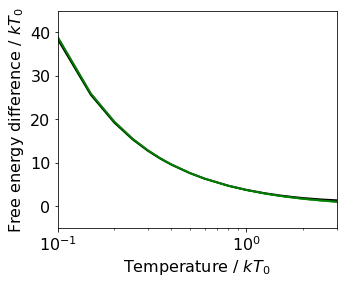

In [103]:
plt.figure(figsize=(5, 4))
plt.plot(temperatures_analysis, dF_true, linewidth=2, color='black', label='Reference')
plt.plot(temperatures_analysis, means, linewidth=2, color='green')
plt.fill_between(temperatures_analysis, means-2.0*uncertainties, means+2.0*uncertainties, color='green', alpha=0.6)
plt.xlabel('Temperature / $kT_0$')
plt.ylabel('Free energy difference / $kT_0$')
plt.semilogx()
plt.xlim(0.1, 3)
plt.ylim(-5, 45)

#plt.legend(loc=3, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/free_energy_2BGs.pdf', bbox_inches='tight', transparent=True)